In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from prophet import Prophet
from datetime import datetime, date
import yfinance as yf

## Data Selection

In [3]:
def stock_price(ticker, start, end):
    df = yf.download(
        ticker, 
        start=start, 
        end=end, 
        progress=False
    )

    df.loc[df['Open'] > df['Close'], 'target'] = 0
    df.loc[df['Open'] < df['Close'], 'target'] = 1
    df.loc[df['Open'] == df['Close'], 'target'] = 0
    df['target'] = df['target'].astype('int')

    return df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,9.13,9.46,9.11,9.43,9.382268,1014200
2021-01-05,9.46,9.58,9.24,9.53,9.481762,885400
2021-01-06,9.40,9.85,9.40,9.47,9.422066,1734900
2021-01-07,9.65,9.70,9.21,9.60,9.551408,2151200
2021-01-08,9.61,9.66,8.92,9.10,9.053939,1643000


In [202]:
# csv = 'HBM.csv'

# def data_refresh(csv):
#     df = pd.read_csv(csv)
#     df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M:%S').dt.date
#     df.rename(columns={'Date':'ds', 'Close':'y'}, inplace=True)
#     df['y-1'] = df['y'].shift(1)
#     df = df[1:]
#     df.loc[df['y'] < df['y-1'], 'target'] = 0
#     df.loc[df['y'] > df['y-1'], 'target'] = 1
#     df.loc[df['y'] == df['y-1'], 'target'] = 0
#     df['target'] = df['target'].astype('int')
#     return df

## Prophet

In [32]:
m = Prophet()
m.fit(df)

14:36:28 - cmdstanpy - INFO - Chain [1] start processing
14:36:28 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
836,2023-12-06 16:00:00
837,2023-12-07 16:00:00
838,2023-12-08 16:00:00
839,2023-12-09 16:00:00
840,2023-12-10 16:00:00


In [34]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
836,2023-12-06 16:00:00,3.150510,1.440014,5.076989
837,2023-12-07 16:00:00,3.026348,1.230011,4.794360
838,2023-12-08 16:00:00,2.949668,1.194930,4.680197
839,2023-12-09 16:00:00,3.293865,1.545467,5.059716
840,2023-12-10 16:00:00,3.184348,1.449467,4.842720


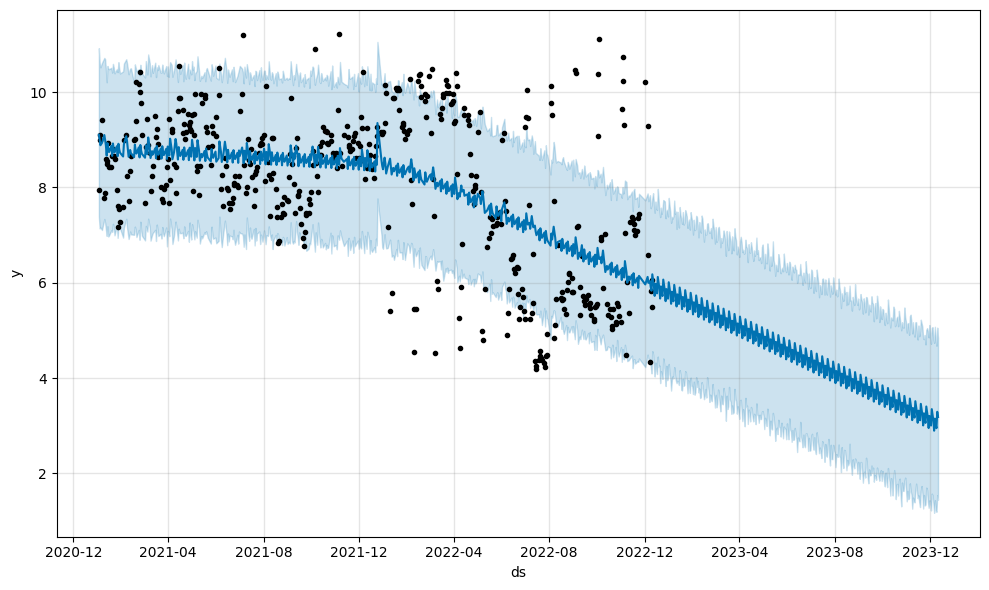

In [35]:
fig1 = m.plot(forecast)

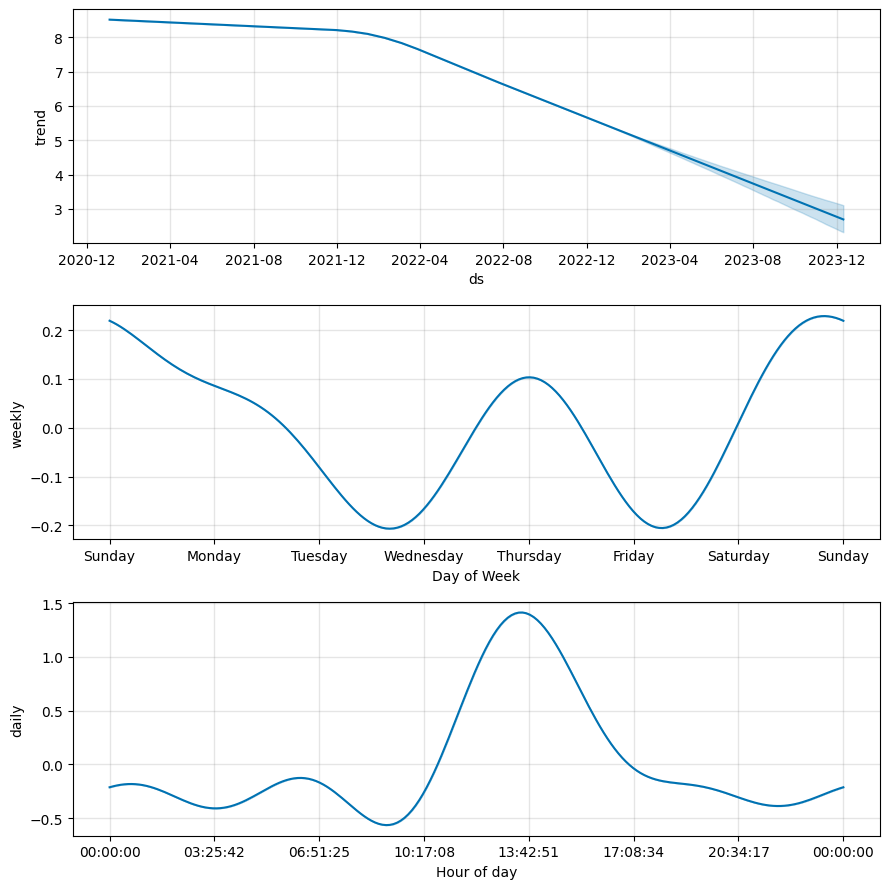

In [18]:
fig2 = m.plot_components(forecast)

In [19]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [20]:
plot_components_plotly(m, forecast)

## ARIMA

In [203]:
df = data_refresh(csv)
df.sort_values('ds', ascending=True)

,ds,y,y-1,target
1,2021-01-05,9.53,9.43,1
2,2021-01-06,9.47,9.53,0
3,2021-01-07,9.60,9.47,1
4,2021-01-08,9.10,9.60,0
5,2021-01-11,8.73,9.10,0
...,...,...,...,...
471,2022-11-17,7.11,7.23,0
472,2022-11-18,7.00,7.11,0
473,2022-11-21,7.09,7.00,1
474,2022-11-22,7.35,7.09,1


In [204]:
df.target.value_counts()

0    245
1    230
Name: target, dtype: int64

In [205]:
df_pivot = pd.pivot_table(df, values='y', index='ds')

In [206]:
def rolling_window(df, window):
    df = df.drop(columns=['y-1', 'target'])
    rolling = df['y'].rolling(window=window)
    rolling_mean = rolling.mean()
    df_concat = pd.concat([df['ds'], rolling_mean], axis=1)
    df_ordered = pd.DataFrame(df_concat).sort_values('ds').reset_index(inplace=False).drop(columns='index')
    df_ordered = df_ordered.set_index('ds')
    df_new = df_ordered[2:]
    return df_new

In [209]:
df_new = rolling_window(df, 3)

predicted=8.918889, expected=8.786667
predicted=8.800000, expected=8.640000
predicted=8.714444, expected=8.593333
predicted=8.673333, expected=8.503333
predicted=8.578889, expected=8.633333
predicted=8.576667, expected=8.713333
predicted=8.616667, expected=8.686667
predicted=8.677778, expected=8.396667
predicted=8.598889, expected=8.046667
predicted=8.376667, expected=7.570000
predicted=8.004444, expected=7.440000
predicted=7.685556, expected=7.330000
predicted=7.446667, expected=7.590000
predicted=7.453333, expected=7.606667
predicted=7.508889, expected=7.740000
predicted=7.645556, expected=7.653333
predicted=7.666667, expected=7.763333
predicted=7.718889, expected=7.916667
predicted=7.777778, expected=8.096667
predicted=7.925556, expected=8.280000
predicted=8.097778, expected=8.366667
predicted=8.247778, expected=8.490000
predicted=8.378889, expected=8.660000
predicted=8.505556, expected=8.863333
predicted=8.671111, expected=9.133333
predicted=8.885556, expected=9.540000
predicted=9.

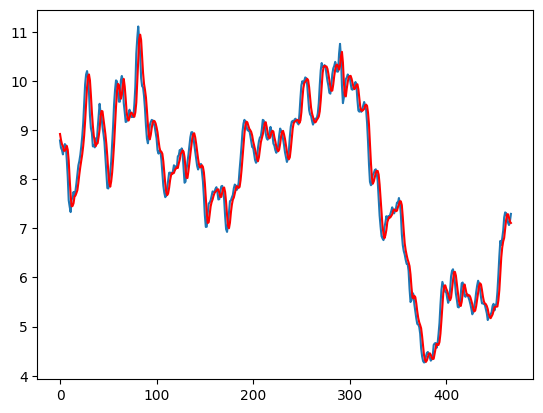

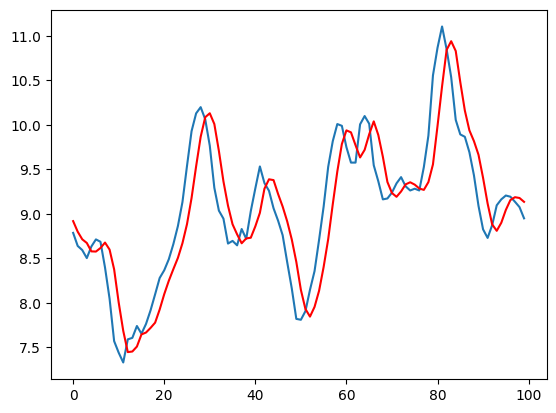

In [208]:
from numpy import mean
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

# prepare situation
X = df_new[2:].values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window, length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()
# zoom plot
pyplot.plot(test[0:100])
pyplot.plot(predictions[0:100], color='red')
pyplot.show()

C:\Users\jrilk\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\jrilk\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\jrilk\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  475
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 -81.745
Date:                Fri, 25 Nov 2022   AIC                            175.490
Time:                        10:53:13   BIC                            200.458
Sample:                             0   HQIC                           185.310
                                - 475                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0488      0.040      1.232      0.218      -0.029       0.127
ar.L2         -0.0126      0.042     -0.301      0.764      -0.095       0.070
ar.L3         -0.0177      0.044     -0.404      0.6

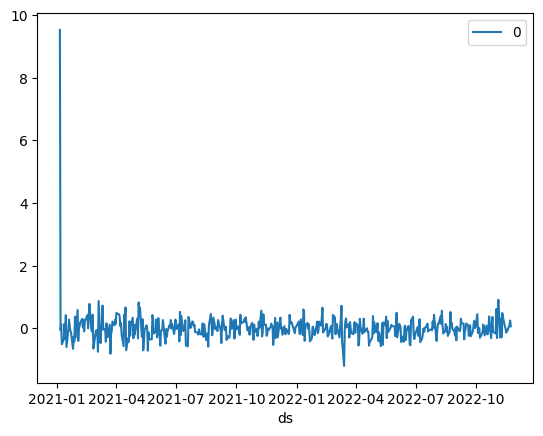

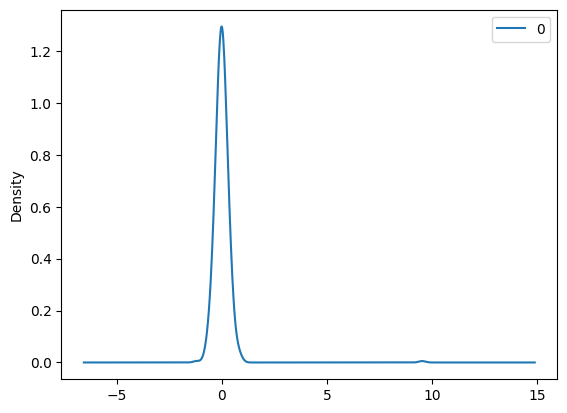

                0
count  475.000000
mean     0.015200
std      0.523487
min     -1.199308
25%     -0.179209
50%     -0.002006
75%      0.167763
max      9.530000


In [210]:
model = ARIMA(df_pivot, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())